In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from omegaconf import OmegaConf

from src.utils import calculate_currents, calculate_voltages  # if needed later
from src.functions import set_time, plotting_solution_gridspec_original
from src.models import synchronous_machine_equations_SM4

In [3]:
def load_machine_params(machine_yaml, Vs=1.0, theta_vs=0.0, f_base=50.0):
    cfg = OmegaConf.load(machine_yaml)

    p = {}
    p["H"] = float(cfg.H)
    p["X_d"] = float(cfg.X_d)
    p["X_d_dash"] = float(cfg.X_d_dash)
    p["X_q"] = float(cfg.X_q)
    p["X_q_dash"] = float(cfg.X_q_dash)
    p["T_d_dash"] = float(cfg.T_d_dash)
    p["T_q_dash"] = float(cfg.T_q_dash)
    p["D"] = float(cfg.D)

    p["omega_B"] = 2 * np.pi * f_base
    p["Vs"] = float(Vs)
    p["theta_vs"] = float(theta_vs)

    p["P_m"] = float(cfg.P_m) if "P_m" in cfg else 0.8
    p["E_fd"] = float(cfg.E_fd) if "E_fd" in cfg else 1.0

    return p

def rhs_sm4(t, x, p):
    return synchronous_machine_equations_SM4(
        t, x,
        p["omega_B"], p["H"], p["P_m"], p["X_q_dash"], p["X_d_dash"], p["D"],
        p["T_d_dash"], p["X_d"], p["E_fd"], p["T_q_dash"], p["X_q"],
        p["Vs"], p["theta_vs"]
    )

def find_equilibrium_by_relaxation(p, x0_guess, t_end=600.0, n=60000, rtol=1e-8, atol=1e-10):
    t_span, t_eval = set_time(end_time=t_end, interval_points=n)

    sol = solve_ivp(
        lambda t, x: rhs_sm4(t, x, p),
        t_span,
        x0_guess,
        t_eval=t_eval,
        rtol=rtol,
        atol=atol
    )

    x_star = sol.y[:, -1]
    return x_star, sol

def equilibrium_residual(p, x_star):
    dx = np.array(rhs_sm4(0.0, x_star, p), dtype=float)
    return dx, float(np.linalg.norm(dx))

def numerical_jacobian(f, x0, eps=1e-6):
    x0 = np.array(x0, dtype=float)
    n = x0.size
    A = np.zeros((n, n), dtype=float)

    for i in range(n):
        h = eps * max(1.0, abs(x0[i]))
        dx = np.zeros(n)
        dx[i] = h
        fp = f(x0 + dx)
        fm = f(x0 - dx)
        A[:, i] = (fp - fm) / (2.0 * h)

    return A

def linear_analysis(p, x_star, eps=1e-6):
    f = lambda x: np.array(rhs_sm4(0.0, x, p), dtype=float)
    A = numerical_jacobian(f, x_star, eps=eps)

    eigvals, eigvecs = np.linalg.eig(A)

    idx = np.argsort(np.real(eigvals))
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    return A, eigvals, eigvecs

def ringdown_simulation(p, x_star, delta_x, t_end=60.0, n=10000, rtol=1e-8, atol=1e-10, method="RK45"):
    x0 = x_star + delta_x
    t_span, t_eval = set_time(end_time=t_end, interval_points=n)

    sol = solve_ivp(
        lambda t, x: rhs_sm4(t, x, p),
        t_span,
        x0,
        t_eval=t_eval,
        rtol=rtol,
        atol=atol,
        method=method
    )
    return sol

def fft_peak_frequency(t, y):
    y0 = y - np.mean(y)
    dt = t[1] - t[0]
    freqs = np.fft.rfftfreq(len(y0), d=dt)
    spec = np.abs(np.fft.rfft(y0))
    k = np.argmax(spec[1:]) + 1
    return float(freqs[k])

def estimate_decay_time_constant(t, y):
    y_abs = np.abs(y)
    y_abs[y_abs == 0] = np.nan
    logy = np.log(y_abs)

    mask = np.isfinite(logy)
    if np.sum(mask) < 10:
        return np.nan

    tt = t[mask]
    ll = logy[mask]

    A = np.vstack([tt, np.ones_like(tt)]).T
    slope, _ = np.linalg.lstsq(A, ll, rcond=None)[0]

    if slope >= 0:
        return np.nan

    return float(-1.0 / slope)

x* = [1.21563384e+00 1.55751856e-11 3.58699204e-01 5.08149692e-01]
||f(x*)|| = 9.486793899190747e-10


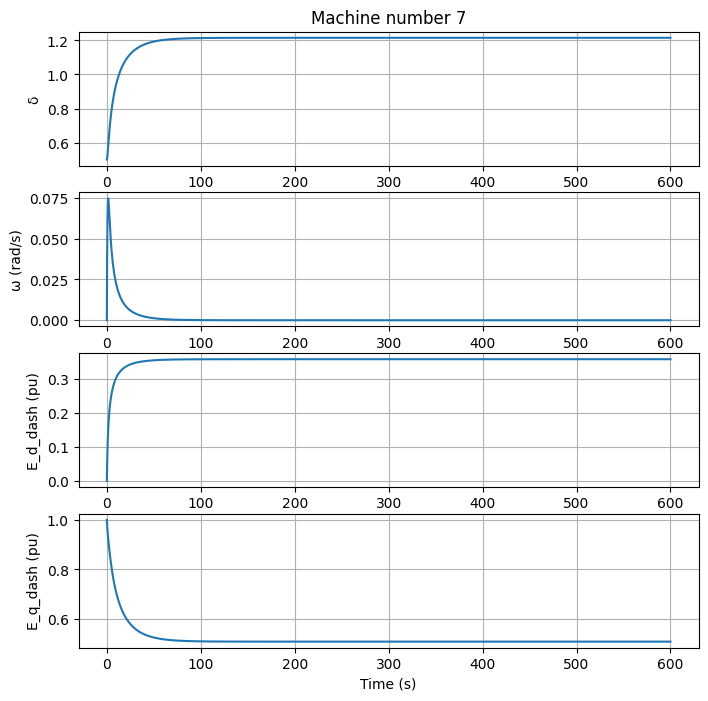

In [4]:
p = load_machine_params("params/machine7.yaml")

x0_guess = np.array([0.5, 0.0, 0.0, 1.0], dtype=float)

x_star, sol_relax = find_equilibrium_by_relaxation(p, x0_guess)
dx_star, res_norm = equilibrium_residual(p, x_star)

print("x* =", x_star)
print("||f(x*)|| =", res_norm)
plotting_solution_gridspec_original(sol_relax, model=7)

In [5]:
A, eigvals, eigvecs = linear_analysis(p, x_star)

print("A =\n", A)
print("eigvals =")
for lam in eigvals:
    print(lam)

A =
 [[  0.           1.           0.           0.        ]
 [-71.34512582 -62.08681134  13.24554377 -87.66863451]
 [  0.1346703    0.          -1.01226994   0.        ]
 [ -0.60524199   0.           0.          -0.8560558 ]]
eigvals =
-60.900304877817554
-1.9936595185229298
-1.0073231381241758
-0.053849542130021556


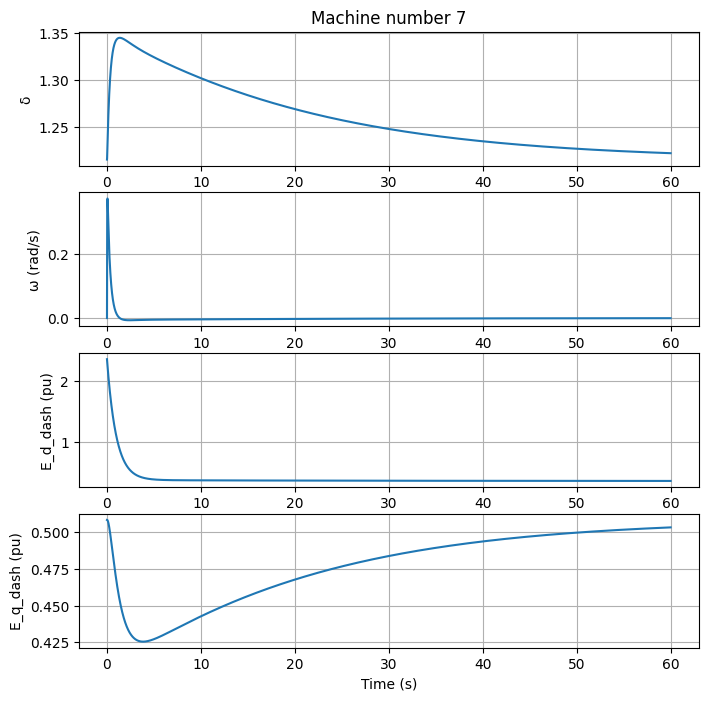

In [25]:
delta_x = np.array([0.0, 0.0, 2, 0.0])
sol_ring = ringdown_simulation(p, x_star, delta_x)

plotting_solution_gridspec_original(sol_ring, model=7)

In [7]:
t = sol_ring.t
delta = sol_ring.y[0]
d_delta = delta - x_star[0]

f_peak = fft_peak_frequency(t, d_delta)
tau = estimate_decay_time_constant(t, d_delta)

print("FFT peak [Hz] =", f_peak)
print("Decay tau [s] =", tau)

FFT peak [Hz] = 0.016665000166650002
Decay tau [s] = 18.60367200268576


verify functions

In [8]:
print("\n===== SM4 VERIFICATION SUMMARY =====")

# --------------------------------------------------
# 1) Equilibrium residual
# --------------------------------------------------
dx_star = np.array(rhs_sm4(0.0, x_star, p), dtype=float)
res_norm = np.linalg.norm(dx_star)

print("\n[1] Equilibrium residual")
print("||f(x*)|| =", res_norm)
print("components =", dx_star)

# --------------------------------------------------
# 2) Power balance check
# --------------------------------------------------
delta, _, E_d, E_q = x_star
I_d, I_q = calculate_currents(
    delta, E_d, E_q,
    p["X_q_dash"], p["X_d_dash"],
    p["Vs"], p["theta_vs"]
)

P_e_star = (
    E_d * I_d
    + E_q * I_q
    + (p["X_q_dash"] - p["X_d_dash"]) * I_d * I_q
)

print("\n[2] Power balance")
print("P_m =", p["P_m"])
print("P_e(x*) =", P_e_star)
print("P_m - P_e =", p["P_m"] - P_e_star)

# --------------------------------------------------
# 3) Jacobian structure sanity
# --------------------------------------------------
print("\n[3] Jacobian structure")
print("∂δ̇/∂ω =", A[0, 1])
print("∂ω̇/∂δ =", A[1, 0])
print("Jacobian diagonal =", np.diag(A))

print("Expected electromagnetic rates:")
print("1/T_d' =", 1 / p["T_d_dash"])
print("1/T_q' =", 1 / p["T_q_dash"])

# --------------------------------------------------
# 4) Eigenvalue summary
# --------------------------------------------------
print("\n[4] Eigenvalues")
for k, lam in enumerate(eigvals):
    print(f"Mode {k+1}: {lam.real:+.4e} {lam.imag:+.4e}j")

# dominant linear frequency
f_lin = 0.0
for lam in eigvals:
    if abs(lam.imag) > 1e-6:
        f_lin = abs(lam.imag) / (2 * np.pi)
        break

print("\nLinear dominant frequency [Hz] =", f_lin)
print("Trajectory FFT frequency [Hz] =", f_peak)

# slowest decay
real_parts = [lam.real for lam in eigvals if lam.real < 0]
tau_lin = -1 / max(real_parts)

print("Linear decay tau [s] =", tau_lin)
print("Trajectory decay tau [s] =", tau)

# --------------------------------------------------
# 5) Local linearity check
# --------------------------------------------------
print("\n[5] Local linearity check")

perturbations = [0.005, 0.01, 0.02]
taus = []

for d in perturbations:
    dx = np.array([d, 0.0, 0.0, 0.0])
    sol = ringdown_simulation(p, x_star, dx)
    d_delta = sol.y[0] - x_star[0]
    tau_d = estimate_decay_time_constant(sol.t, d_delta)
    taus.append(tau_d)

for d, tval in zip(perturbations, taus):
    print(f"Δδ={d:.3f} → tau={tval:.3f} s")

# --------------------------------------------------
# 6) Solver robustness check
# --------------------------------------------------
print("\n[6] Solver robustness")

sol_rk = ringdown_simulation(p, x_star, np.array([0.01, 0, 0, 0]), method="RK45")
sol_rad = ringdown_simulation(p, x_star, np.array([0.01, 0, 0, 0]), method="Radau")

solver_diff = np.max(np.abs(sol_rk.y - sol_rad.y))
print("Max RK45 vs Radau difference =", solver_diff)

print("\n===== END OF VERIFICATION =====")


===== SM4 VERIFICATION SUMMARY =====

[1] Equilibrium residual
||f(x*)|| = 9.486793899190747e-10
components = [ 1.55751856e-11 -9.48551513e-10 -3.49373308e-14  1.56669999e-13]

[2] Power balance
P_m = 0.7
P_e(x*) = 0.6999999999994053
P_m - P_e = 5.946354519892338e-13

[3] Jacobian structure
∂δ̇/∂ω = 1.0
∂ω̇/∂δ = -71.3451258217531
Jacobian diagonal = [  0.         -62.08681134  -1.01226994  -0.8560558 ]
Expected electromagnetic rates:
1/T_d' = 0.21052631578947367
1/T_q' = 0.625

[4] Eigenvalues
Mode 1: -6.0900e+01 +0.0000e+00j
Mode 2: -1.9937e+00 +0.0000e+00j
Mode 3: -1.0073e+00 +0.0000e+00j
Mode 4: -5.3850e-02 +0.0000e+00j

Linear dominant frequency [Hz] = 0.0
Trajectory FFT frequency [Hz] = 0.016665000166650002
Linear decay tau [s] = 18.570260032768076
Trajectory decay tau [s] = 18.60367200268576

[5] Local linearity check
Δδ=0.005 → tau=18.274 s
Δδ=0.010 → tau=18.290 s
Δδ=0.020 → tau=18.324 s

[6] Solver robustness
Max RK45 vs Radau difference = 3.9011127661581213e-10

===== END OF 

In [9]:
def run_case(machine_yaml, P_m_override=None, perturb=None):
    p = load_machine_params(machine_yaml)
    if P_m_override is not None:
        p["P_m"] = float(P_m_override)

    x0_guess = np.array([0.5, 0.0, 0.0, 1.0], dtype=float)
    x_star, sol_relax = find_equilibrium_by_relaxation(p, x0_guess)
    dx_star, res_norm = equilibrium_residual(p, x_star)

    A, eigvals, eigvecs = linear_analysis(p, x_star)

    if perturb is None:
        perturb = np.array([0.01, 0.0, 0.0, 0.0], dtype=float)

    sol_ring = ringdown_simulation(p, x_star, perturb)

    t = sol_ring.t
    d_delta = sol_ring.y[0] - x_star[0]
    f_peak = fft_peak_frequency(t, d_delta)
    tau = estimate_decay_time_constant(t, d_delta)

    out = {
        "p": p,
        "x_star": x_star,
        "res_norm": res_norm,
        "A": A,
        "eigvals": eigvals,
        "eigvecs": eigvecs,
        "sol_relax": sol_relax,
        "sol_ring": sol_ring,
        "f_peak": f_peak,
        "tau": tau,
    }
    return out

In [10]:
cases = [
    ("params/machine1.yaml", None),
    ("params/machine2.yaml", None),
    ("params/machine3.yaml", None),
]

results = []
for yml, pm in cases:
    res = run_case(yml, P_m_override=pm, perturb=np.array([0.01, 0.0, 0.0, 0.0]))
    results.append(res)
    print(yml, "||f(x*)||", res["res_norm"], "f_peak", res["f_peak"])

params/machine1.yaml ||f(x*)|| 4.375038172025834e-10 f_peak 0.016665000166650002
params/machine2.yaml ||f(x*)|| 0.06937256327583324 f_peak 0.016665000166650002
params/machine3.yaml ||f(x*)|| 0.06547173154712461 f_peak 0.033330000333300004


machine1 res_norm= 4.375038172025834e-10 P_m-P_e= 1.3954393196513593e-11 stiff_ratio= 76.44429328614763
machine2 res_norm= 0.06937256327583324 P_m-P_e= 0.06777045692168326 stiff_ratio= 454.57303062109514
machine3 res_norm= 0.06547173154712461 P_m-P_e= 0.04775436438001568 stiff_ratio= 13.838933918406799


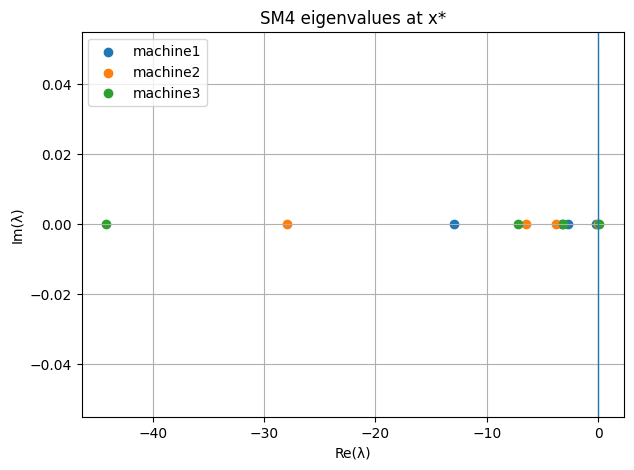

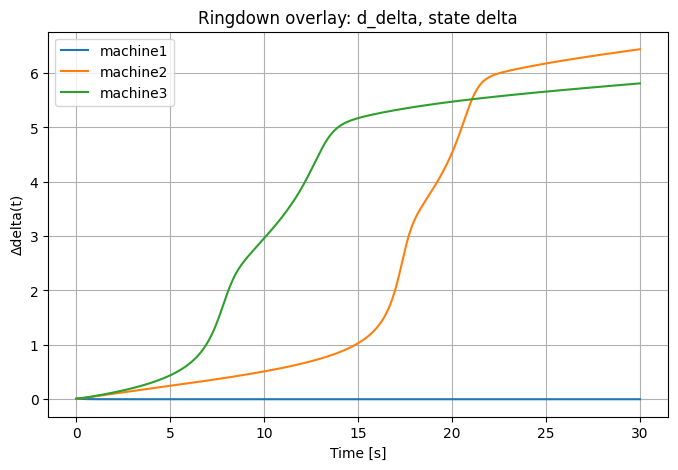

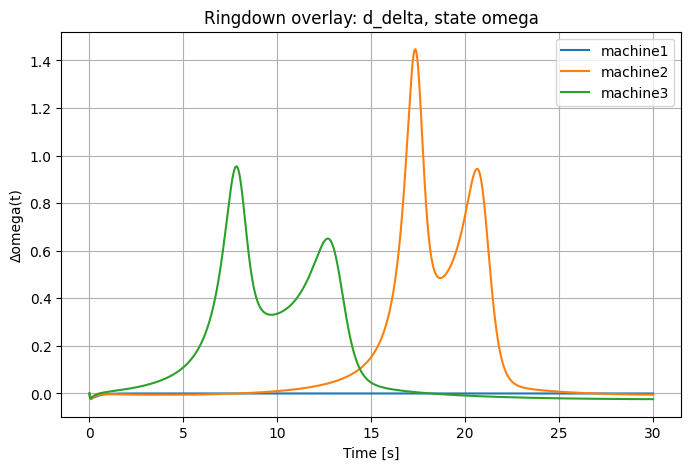

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

state_names = ["delta", "omega", "E_d_dash", "E_q_dash"]

def electrical_power_sm4(x, p):
    delta, omega, E_d, E_q = x
    I_d, I_q = calculate_currents(
        delta, E_d, E_q,
        p["X_q_dash"], p["X_d_dash"],
        p["Vs"], p["theta_vs"]
    )
    P_e = E_d*I_d + E_q*I_q + (p["X_q_dash"] - p["X_d_dash"]) * I_d * I_q
    return float(P_e)

def eig_kpis(eigvals):
    eigvals = np.array(eigvals)
    re = np.real(eigvals)
    im = np.imag(eigvals)

    stable = re < 0
    re_stable = re[stable]

    tau_slow = np.nan
    tau_fast = np.nan
    stiff_ratio = np.nan

    if np.any(stable):
        tau_slow = -1.0 / np.max(re_stable)          # closest to 0 from below
        tau_fast = -1.0 / np.min(re_stable)          # most negative
        stiff_ratio = np.max(np.abs(re_stable)) / np.min(np.abs(re_stable))

    n_complex = int(np.sum(np.abs(im) > 1e-8))
    f_dom = np.nan
    if n_complex > 0:
        k = np.argmax(np.abs(im))
        f_dom = np.abs(im[k]) / (2*np.pi)

    return {
        "tau_slow_lin": float(tau_slow),
        "tau_fast_lin": float(tau_fast),
        "stiff_ratio_lin": float(stiff_ratio),
        "f_dom_lin": float(f_dom),
        "n_complex": n_complex
    }

def participation_table(eigvecs):
    V = np.abs(eigvecs)
    V = V / np.maximum(np.max(V, axis=0, keepdims=True), 1e-12)
    df = pd.DataFrame(V, index=state_names)
    df.columns = [f"mode_{k+1}" for k in range(df.shape[1])]
    return df

def ringdown_kpis(sol, x_star, state_idx=0):
    t = sol.t
    y = sol.y[state_idx] - x_star[state_idx]

    f_peak = fft_peak_frequency(t, y)
    tau = estimate_decay_time_constant(t, y)
    y_max = float(np.max(np.abs(y)))

    return {
        "f_peak_fft": float(f_peak),
        "tau_fit": float(tau),
        "max_abs_dev": float(y_max)
    }

def run_ringdown_suite(p, x_star, t_end=60.0, n=20000, amp=0.01, method="RK45"):
    perts = {
        "d_delta": np.array([amp, 0.0, 0.0, 0.0]),
        "d_omega": np.array([0.0, amp, 0.0, 0.0]),
        "d_Ed":    np.array([0.0, 0.0, amp, 0.0]),
        "d_Eq":    np.array([0.0, 0.0, 0.0, amp]),
    }

    sols = {}
    kpis = {}

    for name, dx in perts.items():
        sol = ringdown_simulation(p, x_star, dx, t_end=t_end, n=n, method=method)
        sols[name] = sol

        # report KPIs on both delta and omega (delta often cleaner for frequency; omega for damping)
        k_delta = ringdown_kpis(sol, x_star, state_idx=0)
        k_omega = ringdown_kpis(sol, x_star, state_idx=1)

        kpis[name] = {
            **{f"delta_{k}": v for k, v in k_delta.items()},
            **{f"omega_{k}": v for k, v in k_omega.items()},
        }

    return sols, kpis

def analyze_machine(machine_yaml, machine_id=None,
                    relax_t=600.0, relax_n=60000,
                    ring_t=60.0, ring_n=20000,
                    amp=0.01):
    p = load_machine_params(machine_yaml)

    x0_guess = np.array([0.5, 0.0, 0.0, 1.0], dtype=float)

    x_star, sol_relax = find_equilibrium_by_relaxation(p, x0_guess, t_end=relax_t, n=relax_n)
    dx_star, res_norm = equilibrium_residual(p, x_star)

    P_e = electrical_power_sm4(x_star, p)
    P_m = p["P_m"]

    A, eigvals, eigvecs = linear_analysis(p, x_star)
    eig_summary = eig_kpis(eigvals)

    sols_ring, ring_kpis = run_ringdown_suite(p, x_star, t_end=ring_t, n=ring_n, amp=amp)

    out = {
        "machine_yaml": machine_yaml,
        "machine_id": machine_id if machine_id is not None else os.path.basename(machine_yaml),
        "p": p,
        "x_star": x_star,
        "dx_star": dx_star,
        "res_norm": float(res_norm),
        "P_m": float(P_m),
        "P_e": float(P_e),
        "P_m_minus_P_e": float(P_m - P_e),
        "A": A,
        "eigvals": eigvals,
        "eigvecs": eigvecs,
        "eig_summary": eig_summary,
        "sol_relax": sol_relax,
        "sols_ring": sols_ring,
        "ring_kpis": ring_kpis,
        "participation": participation_table(eigvecs),
    }
    return out

def build_results_table(machine_results):
    rows = []
    for r in machine_results:
        base = {
            "machine_id": r["machine_id"],
            "yaml": r["machine_yaml"],
            "res_norm": r["res_norm"],
            "P_m": r["P_m"],
            "P_e": r["P_e"],
            "P_m_minus_P_e": r["P_m_minus_P_e"],
            "H": r["p"]["H"],
            "D": r["p"]["D"],
            "T_d_dash": r["p"]["T_d_dash"],
            "T_q_dash": r["p"]["T_q_dash"],
            "X_d": r["p"]["X_d"],
            "X_d_dash": r["p"]["X_d_dash"],
            "X_q": r["p"]["X_q"],
            "X_q_dash": r["p"]["X_q_dash"],
            "Vs": r["p"]["Vs"],
            "theta_vs": r["p"]["theta_vs"],
        }

        base.update(r["eig_summary"])

        for pert_name, kpis in r["ring_kpis"].items():
            for k, v in kpis.items():
                base[f"{pert_name}_{k}"] = v

        rows.append(base)

    return pd.DataFrame(rows)

def save_results(machine_results, out_dir="results_sm4"):
    os.makedirs(out_dir, exist_ok=True)

    df = build_results_table(machine_results)
    df.to_csv(os.path.join(out_dir, "sm4_summary.csv"), index=False)

    for r in machine_results:
        mid = r["machine_id"].replace(".yaml", "")
        np.savez_compressed(
            os.path.join(out_dir, f"{mid}_arrays.npz"),
            x_star=r["x_star"],
            dx_star=r["dx_star"],
            A=r["A"],
            eigvals=r["eigvals"],
            eigvecs=r["eigvecs"],
        )
        r["participation"].to_csv(os.path.join(out_dir, f"{mid}_participation.csv"))

    return df

def plot_eigs(machine_results):
    plt.figure(figsize=(7, 5))
    for r in machine_results:
        lam = r["eigvals"]
        plt.scatter(np.real(lam), np.imag(lam), label=r["machine_id"])
    plt.axvline(0.0, linewidth=1)
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("SM4 eigenvalues at x*")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_ringdown_overlay(machine_results, pert="d_delta", state_idx=0, t_max=30.0):
    plt.figure(figsize=(8, 5))
    for r in machine_results:
        sol = r["sols_ring"][pert]
        t = sol.t
        y = sol.y[state_idx] - r["x_star"][state_idx]
        mask = t <= t_max
        plt.plot(t[mask], y[mask], label=r["machine_id"])
    plt.xlabel("Time [s]")
    plt.ylabel(f"Δ{state_names[state_idx]}(t)")
    plt.title(f"Ringdown overlay: {pert}, state {state_names[state_idx]}")
    plt.grid(True)
    plt.legend()
    plt.show()

# -------------------------
# Run 3-machine suite
# -------------------------
machines = [
    ("params/machine1.yaml", "machine1"),
    ("params/machine2.yaml", "machine2"),
    ("params/machine3.yaml", "machine3"),
]

machine_results = []
for yml, mid in machines:
    r = analyze_machine(
        yml,
        machine_id=mid,
        relax_t=600.0,
        relax_n=60000,
        ring_t=60.0,
        ring_n=20000,
        amp=0.01
    )
    machine_results.append(r)
    print(mid, "res_norm=", r["res_norm"], "P_m-P_e=", r["P_m_minus_P_e"], "stiff_ratio=", r["eig_summary"]["stiff_ratio_lin"])

df = save_results(machine_results, out_dir="results_sm4")
df

# -------------------------
# Core plots
# -------------------------
plot_eigs(machine_results)
plot_ringdown_overlay(machine_results, pert="d_delta", state_idx=0, t_max=30.0)
plot_ringdown_overlay(machine_results, pert="d_delta", state_idx=1, t_max=30.0)

In [12]:
def plot_relaxation_and_ringdowns(result, t_max_relax=200.0, t_max_ring=30.0):
    x_star = result["x_star"]

    # -------------------------
    # Relaxation trajectory
    # -------------------------
    sol_relax = result["sol_relax"]
    t = sol_relax.t
    mask = t <= t_max_relax

    fig, axs = plt.subplots(4, 1, figsize=(8, 9), sharex=True)
    for i, name in enumerate(state_names):
        axs[i].plot(t[mask], sol_relax.y[i][mask])
        axs[i].set_ylabel(name)
        axs[i].grid(True)

    axs[-1].set_xlabel("Time [s]")
    fig.suptitle(f"Relaxation to equilibrium — {result['machine_id']}")
    plt.show()

    # -------------------------
    # Ringdown trajectories
    # -------------------------
    for pert_name, sol in result["sols_ring"].items():
        t = sol.t
        mask = t <= t_max_ring

        fig, axs = plt.subplots(4, 1, figsize=(8, 9), sharex=True)
        for i, name in enumerate(state_names):
            axs[i].plot(t[mask], sol.y[i][mask] - x_star[i])
            axs[i].set_ylabel(f"Δ{name}")
            axs[i].grid(True)

        axs[-1].set_xlabel("Time [s]")
        fig.suptitle(f"Ringdown — {pert_name} — {result['machine_id']}")
        plt.show()

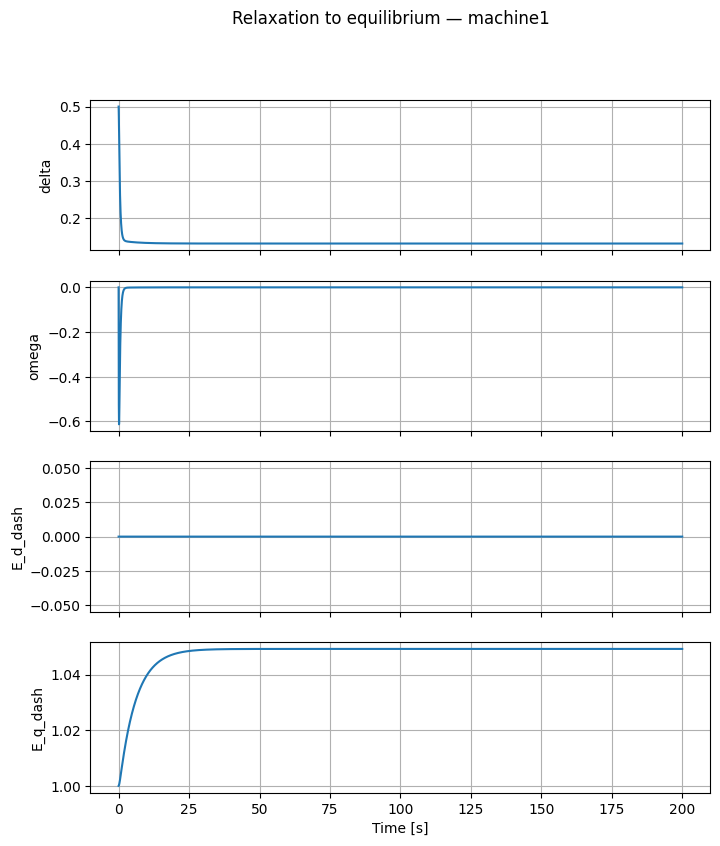

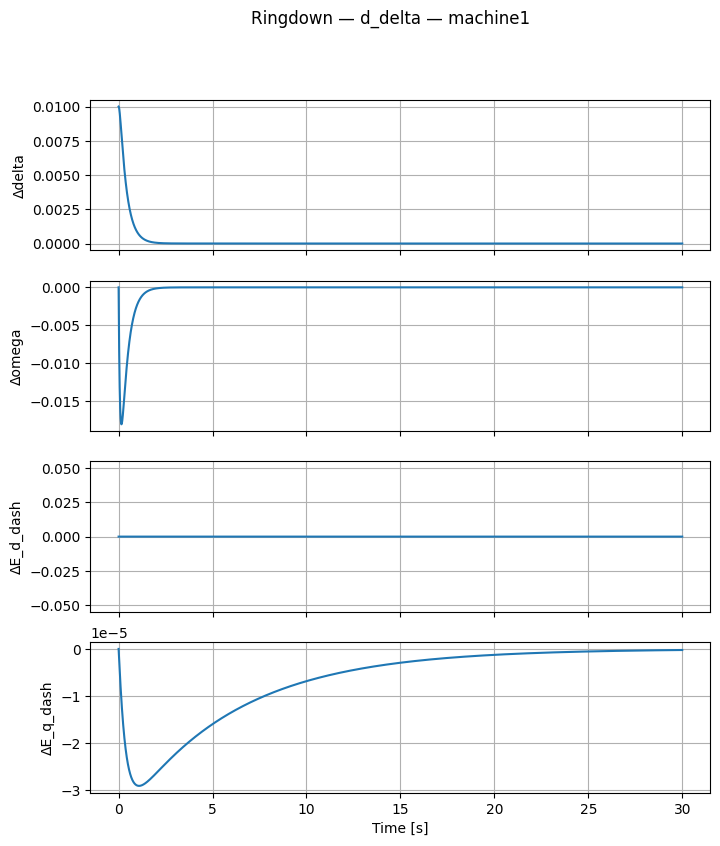

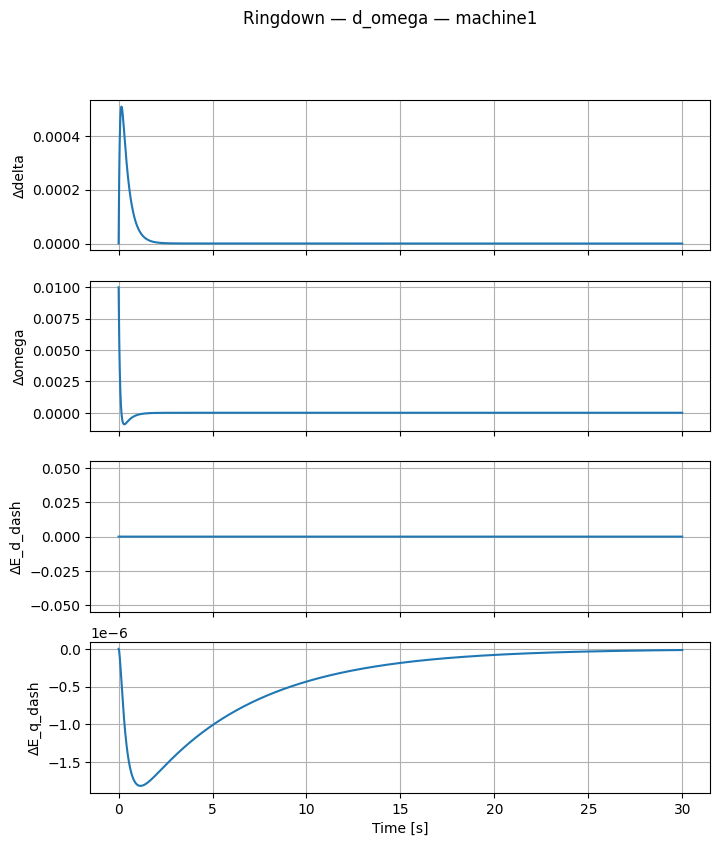

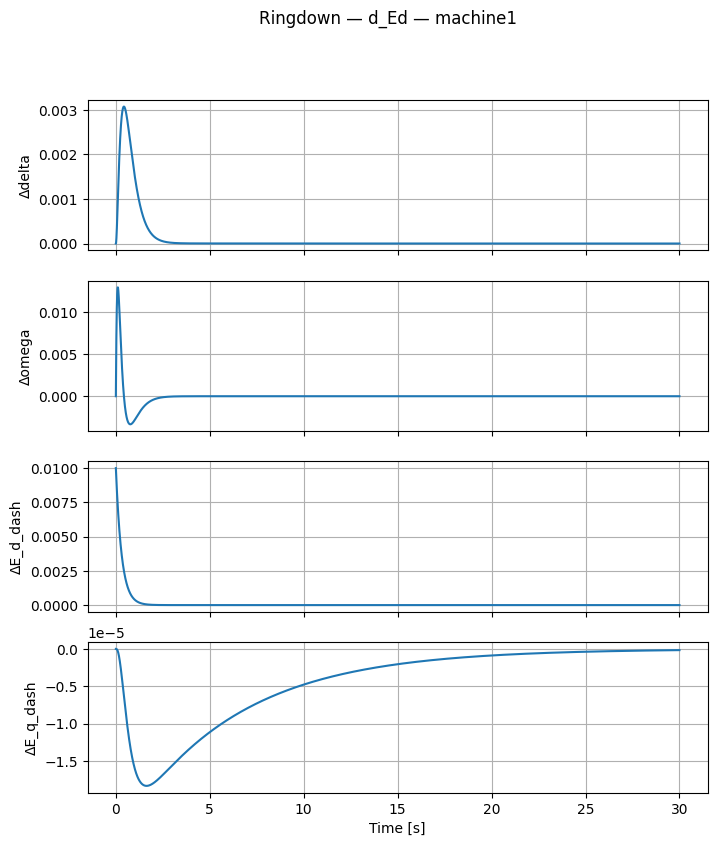

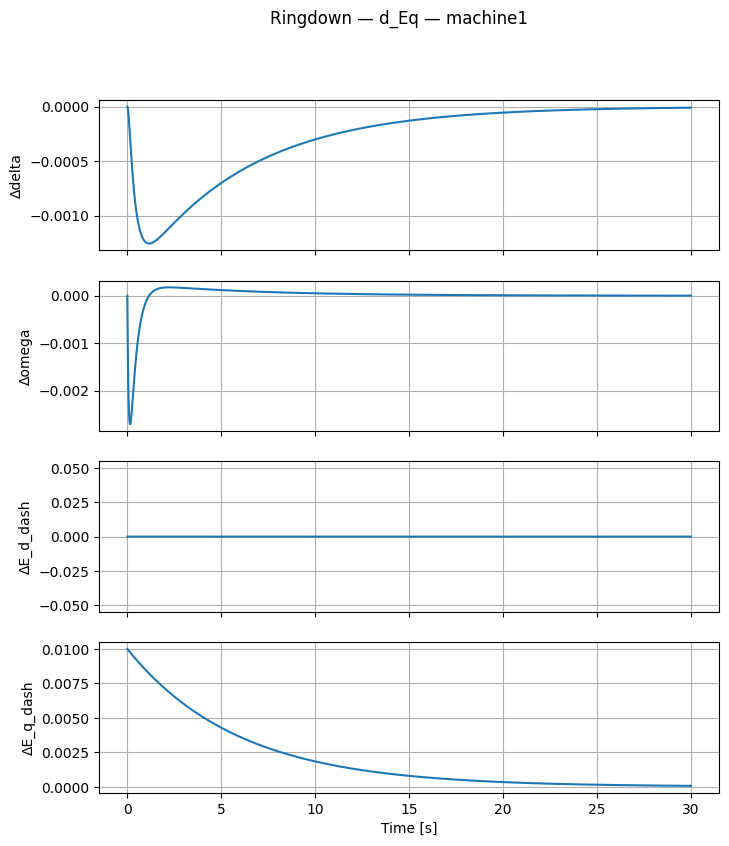

In [13]:
plot_relaxation_and_ringdowns(machine_results[0])

In [14]:
def plot_ringdown_overlay_all_machines(machine_results,
                                       pert="d_delta",
                                       state_idx=0,
                                       t_max=30.0):
    plt.figure(figsize=(8, 5))

    for r in machine_results:
        sol = r["sols_ring"][pert]
        t = sol.t
        y = sol.y[state_idx] - r["x_star"][state_idx]
        mask = t <= t_max
        plt.plot(t[mask], y[mask], label=r["machine_id"])

    plt.xlabel("Time [s]")
    plt.ylabel(f"Δ{state_names[state_idx]}(t)")
    plt.title(f"Ringdown comparison — {pert}, state {state_names[state_idx]}")
    plt.grid(True)
    plt.legend()
    plt.show()

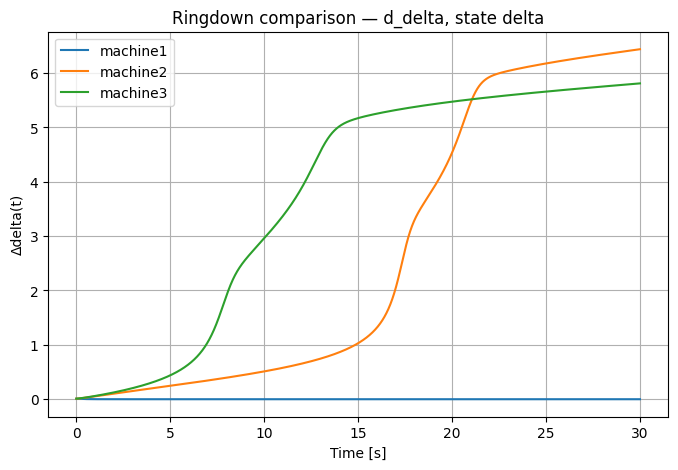

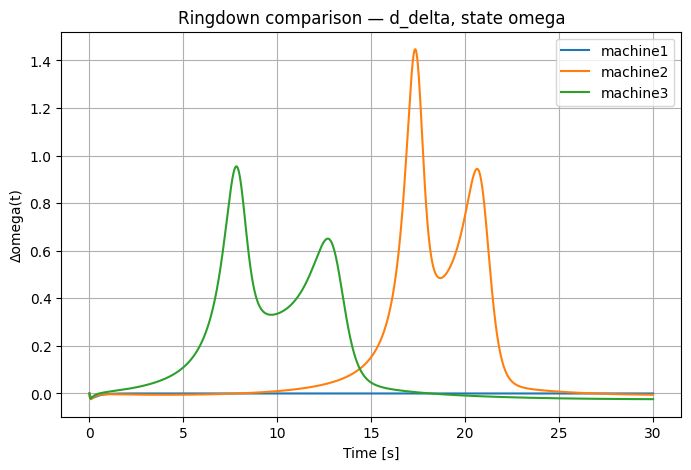

In [15]:
plot_ringdown_overlay_all_machines(machine_results, pert="d_delta", state_idx=0)
plot_ringdown_overlay_all_machines(machine_results, pert="d_delta", state_idx=1)

In [61]:
state_names = ["delta", "omega", "E_d'", "E_q'"]

def plot_reference_trajectory(sol, t_max=None):
    t = sol.t
    X = sol.y

    if t_max is not None:
        mask = t <= t_max
        t = t[mask]
        X = X[:, mask]

    fig, axs = plt.subplots(X.shape[0], 1, figsize=(8, 9), sharex=True)

    for i, ax in enumerate(axs):
        ax.plot(t, X[i])
        ax.set_ylabel(state_names[i])
        ax.grid(True)

    axs[-1].set_xlabel("Time [s]")
    fig.suptitle("Reference trajectory (fixed system parameters)")
    plt.show()

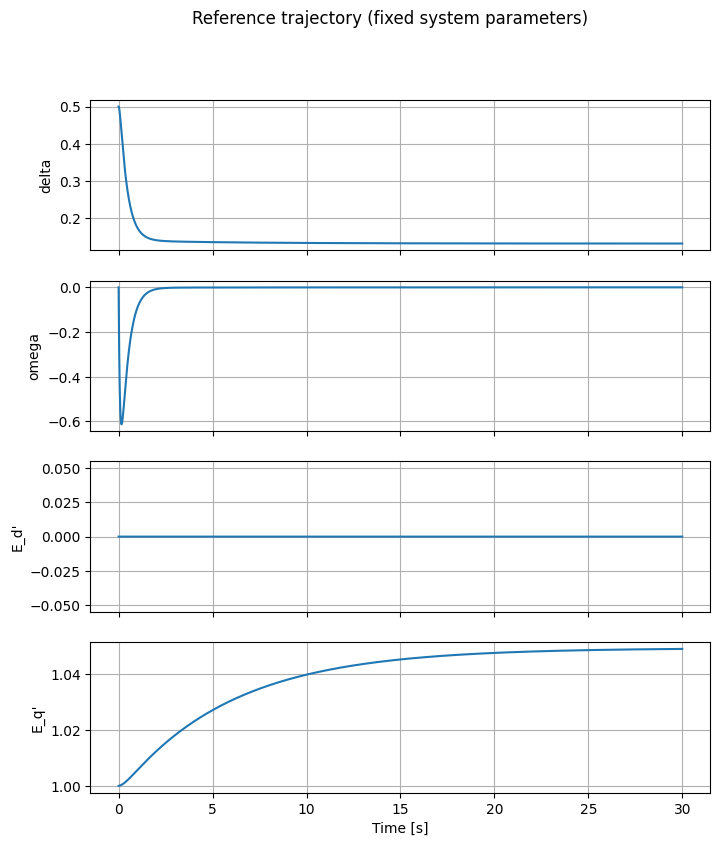

In [97]:
# --------------------------------------------------
# Baseline reference trajectory (Machine 1, fixed params)
# --------------------------------------------------
p = load_machine_params("params/machine1.yaml")

x0_guess = np.array([0.5, 0.0, 0.0, 1.0], dtype=float)

T_ref = 200.0
N_ref = 20000

sol_ref = solve_ivp(
    lambda t, x: rhs_sm4(t, x, p),
    (0.0, T_ref),
    x0_guess,
    t_eval=np.linspace(0.0, T_ref, N_ref),
    rtol=1e-8,
    atol=1e-10
)

# convenience
t_ref = sol_ref.t
X_ref = sol_ref.y

plot_reference_trajectory(sol_ref, t_max=30)

In [98]:
operating_points = [
    {
        "op_id": "OP1_transient",
        "t_ref": 0.5,
        "desc": "Early fast transient regime"
    },
    {
        "op_id": "OP2_intermediate",
        "t_ref": 2.5,
        "desc": "Intermediate decay regime"
    },
    {
        "op_id": "OP3_slow_tail",
        "t_ref": 12.0,
        "desc": "Slow electromagnetic regime"
    },
]

In [99]:
def extract_state_at_time(sol, t_target):
    idx = np.argmin(np.abs(sol.t - t_target))
    return sol.y[:, idx], sol.t[idx]

for op in operating_points:
    x_ref_i, t_i = extract_state_at_time(sol_ref, op["t_ref"])
    op["x_ref"] = x_ref_i
    op["t_actual"] = t_i

    print(op["op_id"], "t =", round(t_i, ), "\t x_ref =", np.round(x_ref_i, 4))

OP1_transient t = 1 	 x_ref = [ 0.2656 -0.3195  0.      1.0022]
OP2_intermediate t = 3 	 x_ref = [ 0.1385 -0.0029  0.      1.0154]
OP3_slow_tail t = 12 	 x_ref = [ 1.3310e-01 -2.0000e-04  0.0000e+00  1.0425e+00]


In [100]:
def settling_time(t, y, tol_frac=0.02):
    """
    Time until |y(t)| stays below tol_frac * max(|y|).
    """
    y_abs = np.abs(y)
    y_max = np.max(y_abs)
    tol = tol_frac * y_max

    for i in range(len(t)):
        if np.all(y_abs[i:] <= tol):
            return float(t[i])
    return np.nan

def initial_slope(t, y, window=0.1):
    mask = t <= window
    if np.sum(mask) < 2:
        return np.nan
    dy = np.gradient(y[mask], t[mask])
    return float(np.max(np.abs(dy)))

def trajectory_kpis(sol, x_ref, state_idx=0):
    t = sol.t
    y = sol.y[state_idx] - x_ref[state_idx]

    return {
        "max_dev": float(np.max(np.abs(y))),
        "settling_time_2pct": settling_time(t, y, tol_frac=0.02),
        "initial_slope": initial_slope(t, y)
    }

In [101]:
regimes = [
    {"id": "small", "delta_x": np.array([0.1, 0.0, 0.0, 0.0])},
    {"id": "large", "delta_x": np.array([0.40, 0.0, 0.0, 0.0])},
]

In [102]:
results = []

for op in operating_points:
    for reg in regimes:
        sol = ringdown_simulation(
            p,
            x_star=op["x_ref"],
            delta_x=reg["delta_x"],
            t_end=10.0,
            n=20000
        )

        k_delta = trajectory_kpis(sol, op["x_ref"], state_idx=0)
        k_omega = trajectory_kpis(sol, op["x_ref"], state_idx=1)

        results.append({
            "op_id": op["op_id"],
            "t_op": op["t_actual"],
            "regime": reg["id"],
            "delta_x": reg["delta_x"][0],
            **{f"delta_{k}": v for k, v in k_delta.items()},
            **{f"omega_{k}": v for k, v in k_omega.items()},
        })

In [103]:
import pandas as pd
df_traj = pd.DataFrame(results)
df_traj

,op_id,t_op,regime,delta_x,delta_max_dev,delta_settling_time_2pct,delta_initial_slope,omega_max_dev,omega_settling_time_2pct,omega_initial_slope
0,OP1_transient,0.500025,small,0.1,0.132144,NaN,0.409232,0.319266,NaN,2.527117
1,OP1_transient,0.500025,large,0.4,0.400000,NaN,0.871428,0.574269,NaN,12.107630
2,OP2_intermediate,2.500125,small,0.1,0.100000,NaN,0.165399,0.174099,1.5545,3.398036
3,OP2_intermediate,2.500125,large,0.4,0.400000,1.5105,0.644035,0.689146,1.6920,13.367836
4,OP3_slow_tail,12.000600,small,0.1,0.100000,1.4870,0.168102,0.179592,1.6710,3.514017
5,OP3_slow_tail,12.000600,large,0.4,0.400000,1.5355,0.661080,0.708791,1.6895,13.802088


In [106]:
def plot_reference_with_ops(sol_ref, operating_points):
    t = sol_ref.t
    x = sol_ref.y

    fig, axs = plt.subplots(4, 1, figsize=(9, 9), sharex=True)
    labels = ["δ", "ω", "E′d", "E′q"]

    for i in range(4):
        axs[i].plot(t, x[i], lw=1.8)
        for op in operating_points:
            axs[i].axvline(op["t_actual"], ls="--", alpha=0.5)
        axs[i].set_ylabel(labels[i])
        axs[i].grid(True)
    
    axs[-1].set_xlabel("Time [s]")
    axs[-1].set_xlim(0, 20)
    fig.suptitle("Reference trajectory with operating points")
    plt.show()

def plot_ringdowns_per_op(op, ringdown_solutions):
    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    for regime, sol in ringdown_solutions.items():
        t = sol.t
        d_delta = sol.y[0] - op["x_ref"][0]
        d_omega = sol.y[1] - op["x_ref"][1]

        axs[0].plot(t, d_delta, label=regime)
        axs[1].plot(t, d_omega, label=regime)

    axs[0].set_ylabel("Δδ")
    axs[1].set_ylabel("Δω")
    axs[1].set_xlabel("Time [s]")

    for ax in axs:
        ax.grid(True)
        ax.legend()

    fig.suptitle(f"Ringdowns around {op['op_id']} (t={op['t_actual']:.2f}s)")
    plt.show()

def plot_same_regime_across_ops(operating_points, ringdown_map, regime="small"):
    plt.figure(figsize=(8, 5))

    for op in operating_points:
        sol = ringdown_map[op["op_id"]][regime]
        t = sol.t
        d_delta = sol.y[0] - op["x_ref"][0]
        plt.plot(t, d_delta, label=op["op_id"])

    plt.xlabel("Time [s]")
    plt.ylabel("Δδ")
    plt.title(f"Comparison of {regime} perturbation across operating points")
    plt.grid(True)
    plt.legend()
    plt.show()

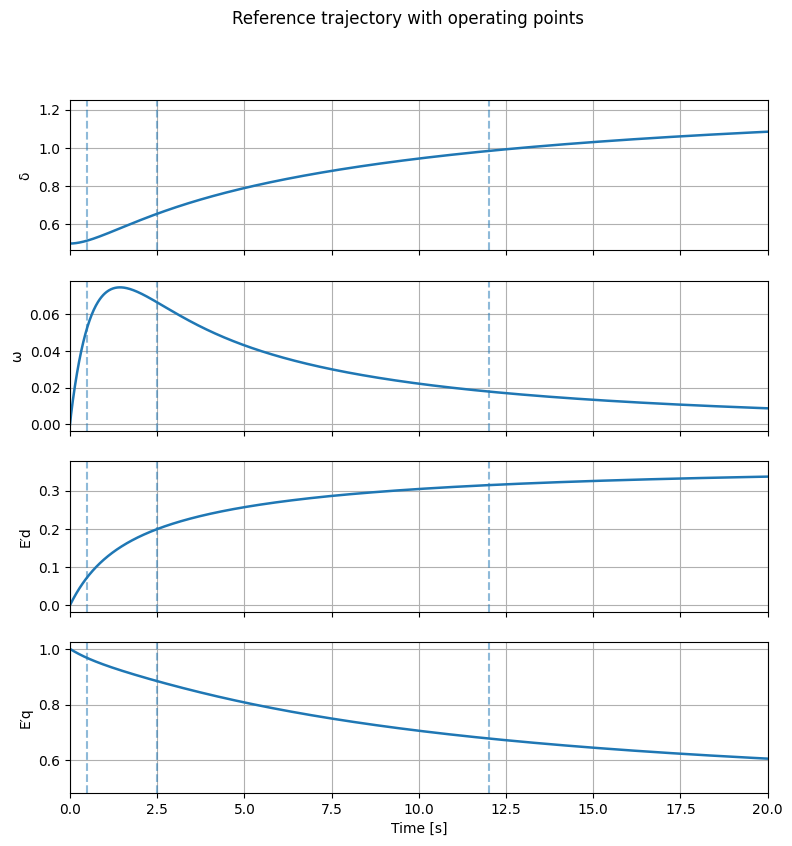

In [107]:
plot_reference_with_ops(sol_relax, operating_points)

In [108]:
ringdown_map = {}

for op in operating_points:
    ringdown_map[op["op_id"]] = {}

    # small perturbation
    ringdown_map[op["op_id"]]["small"] = ringdown_simulation(
        p,
        x_star=op["x_ref"],
        delta_x=np.array([0.01, 0.0, 0.0, 0.0]),
        t_end=10.0,
        n=20000
    )

    # large perturbation
    ringdown_map[op["op_id"]]["large"] = ringdown_simulation(
        p,
        x_star=op["x_ref"],
        delta_x=np.array([0.20, 0.0, 0.0, 0.0]),
        t_end=10.0,
        n=20000
    )

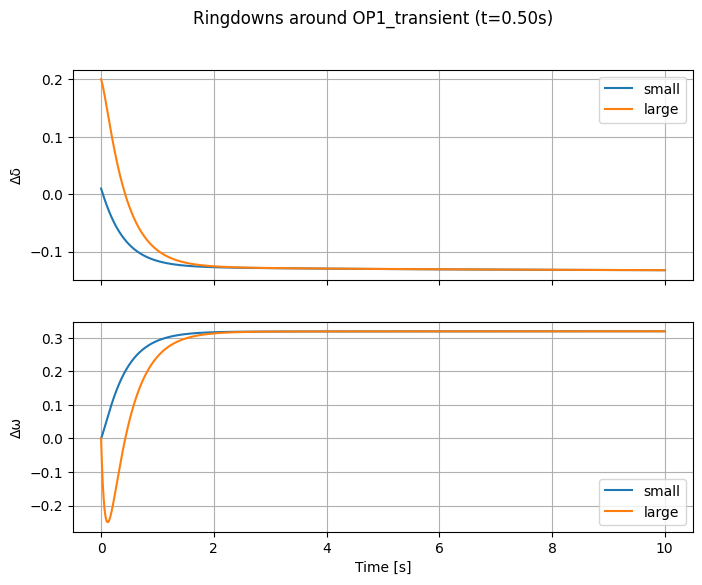

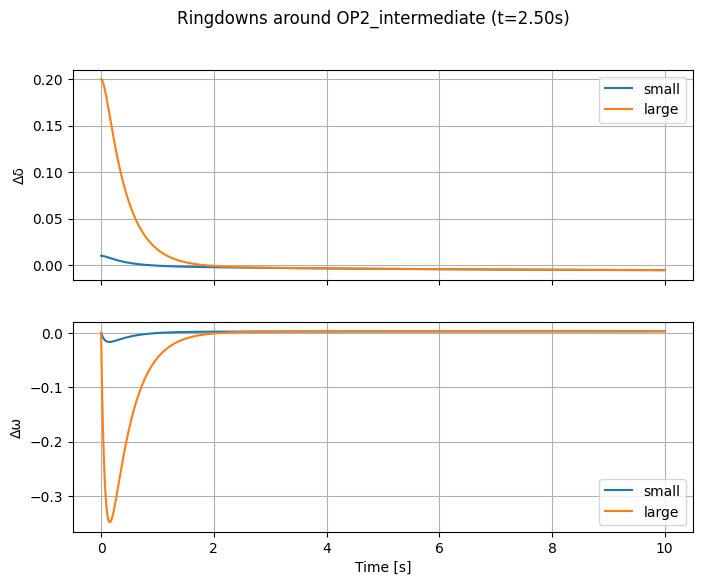

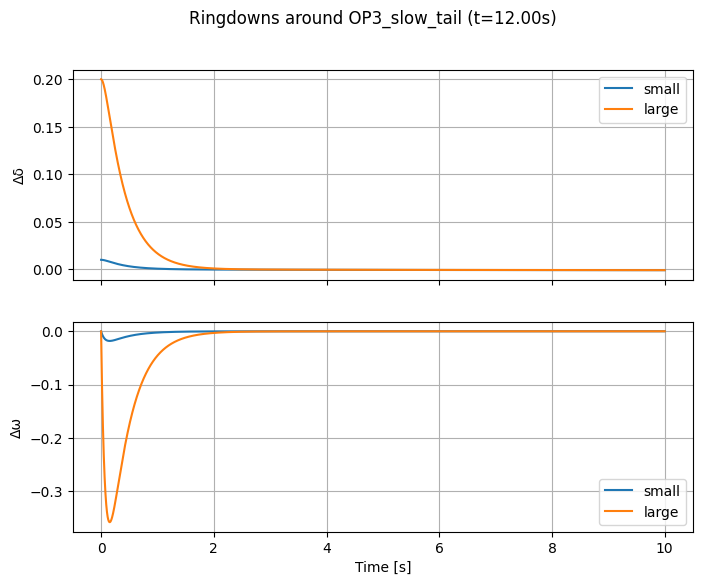

In [109]:
for op in operating_points:
    plot_ringdowns_per_op(op, ringdown_map[op["op_id"]])

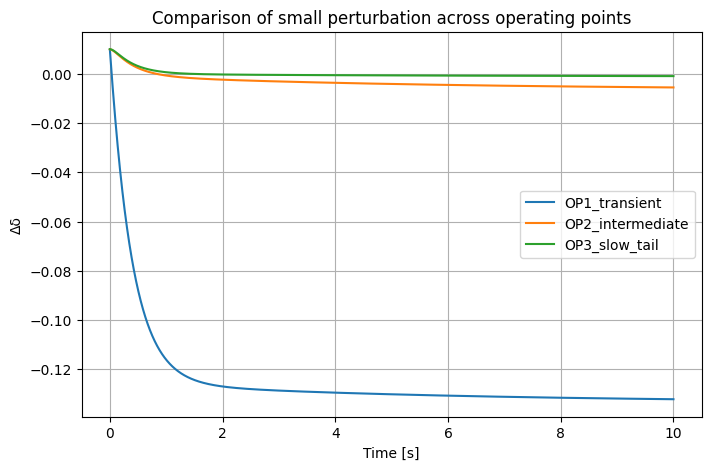

In [88]:
plot_same_regime_across_ops(
    operating_points,
    ringdown_map,
    regime="small"
)

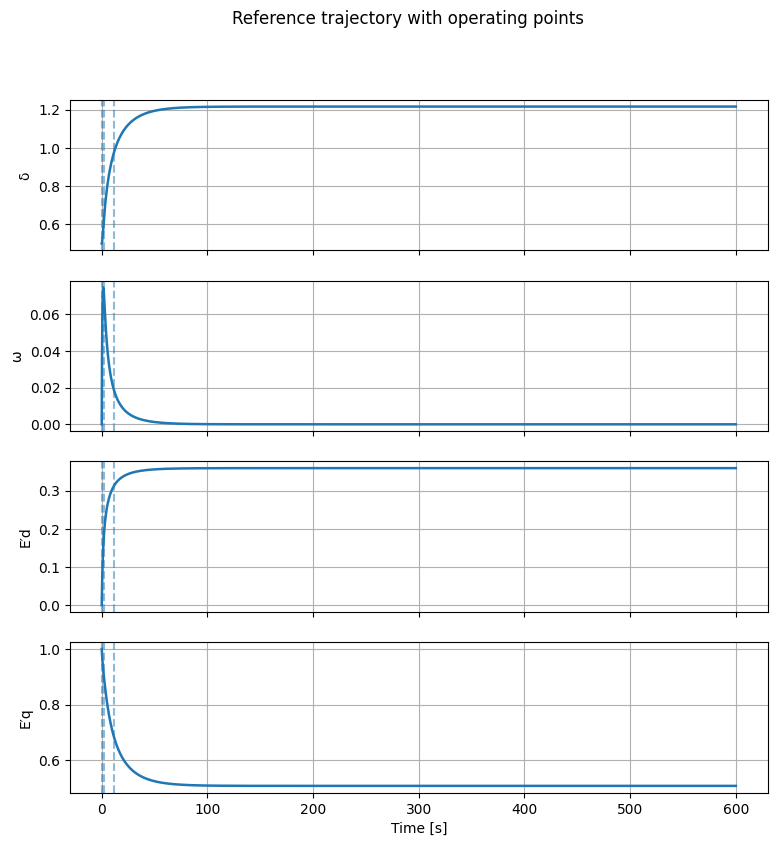

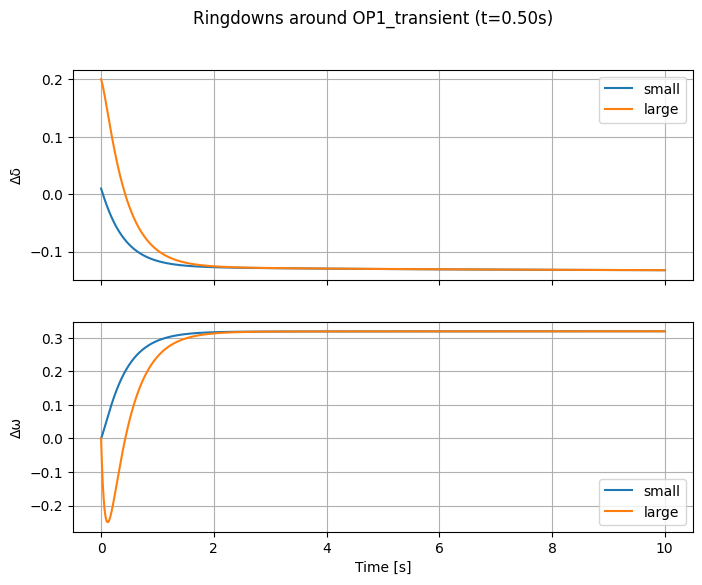

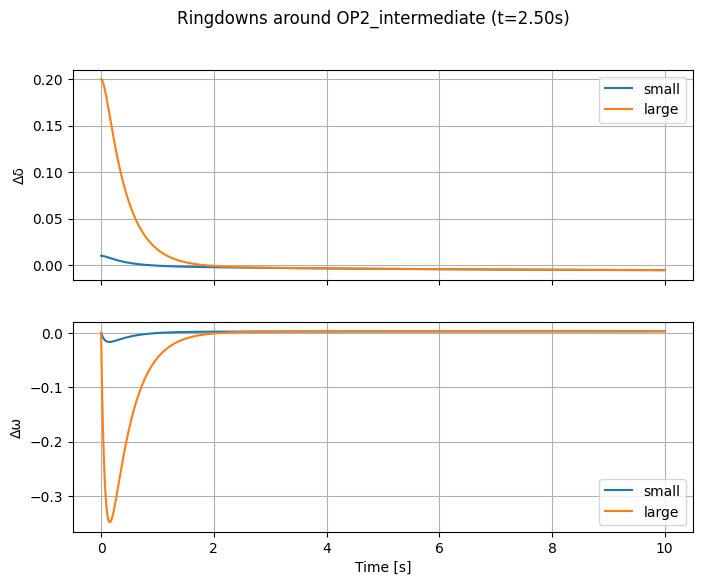

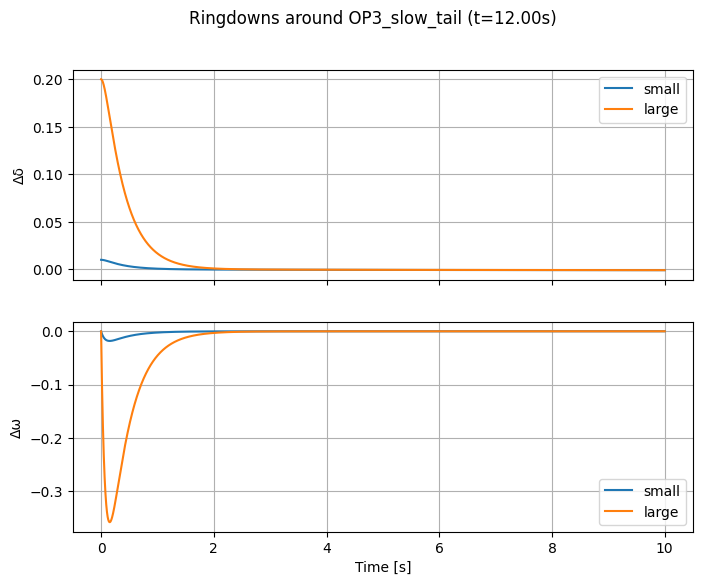

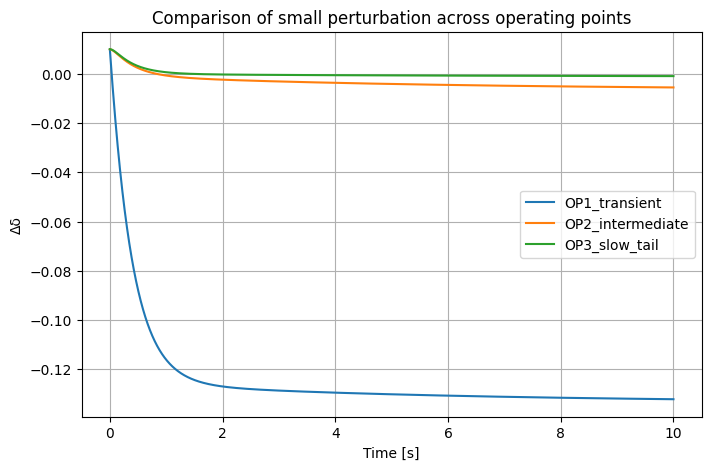

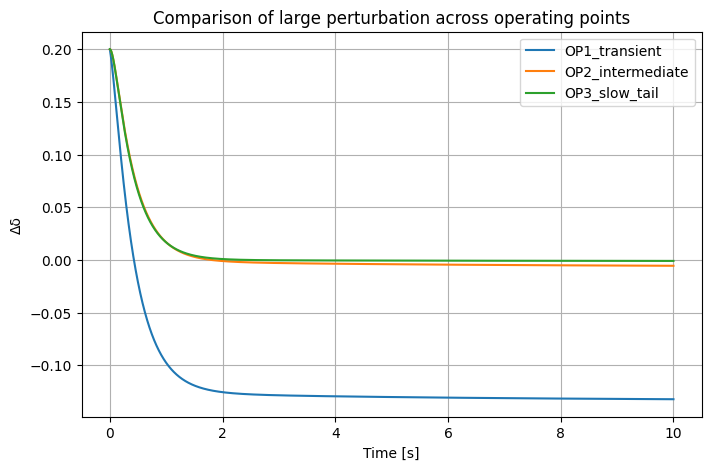

In [89]:
# 1) Global context
plot_reference_with_ops(sol_relax, operating_points)

# 2) Local behaviour per OP
for op in operating_points:
    plot_ringdowns_per_op(op, ringdown_map[op["op_id"]])

# 3) Regime comparison across OPs
plot_same_regime_across_ops(operating_points, ringdown_map, regime="small")
plot_same_regime_across_ops(operating_points, ringdown_map, regime="large")

In [90]:
def summarize_op_linear(p, operating_points, eps=1e-6):
    for op in operating_points:
        x_ref = op["x_ref"]
        A, eigvals, eigvecs = linear_analysis(p, x_ref, eps=eps)

        op["A"] = A
        op["eigvals"] = eigvals
        op["eigvecs"] = eigvecs
        op["eig_summary"] = eig_kpis(eigvals)

        print("\n", "="*60)
        print(op["op_id"], "t =", round(op["t_actual"], 2))
        print("x_ref =", np.array2string(x_ref, precision=4))
        print("Linear KPIs:", op["eig_summary"])
        print("Eigenvalues:")
        for lam in eigvals:
            print(f"  {lam.real:+.4e} {lam.imag:+.4e}j")

summarize_op_linear(p, operating_points)


OP1_transient t = 0.5
x_ref = [ 0.2656 -0.3195  0.      1.0022]
Linear KPIs: {'tau_slow_lin': 6.050108255870056, 'tau_fast_lin': 0.07593944778218875, 'stiff_ratio_lin': 79.6701639604111, 'f_dom_lin': nan, 'n_complex': 0}
Eigenvalues:
  -1.3168e+01 +0.0000e+00j
  -3.2258e+00 +0.0000e+00j
  -2.5450e+00 +0.0000e+00j
  -1.6529e-01 +0.0000e+00j

OP2_intermediate t = 2.5
x_ref = [ 0.1385 -0.0029  0.      1.0154]
Linear KPIs: {'tau_slow_lin': 5.907748309447264, 'tau_fast_lin': 0.07639554065970686, 'stiff_ratio_lin': 77.3310622378143, 'f_dom_lin': nan, 'n_complex': 0}
Eigenvalues:
  -1.3090e+01 +0.0000e+00j
  -3.2258e+00 +0.0000e+00j
  -2.6197e+00 +0.0000e+00j
  -1.6927e-01 +0.0000e+00j

OP3_slow_tail t = 12.0
x_ref = [ 1.3311e-01 -1.9275e-04  0.0000e+00  1.0425e+00]
Linear KPIs: {'tau_slow_lin': 5.902203872306819, 'tau_fast_lin': 0.0770315342738058, 'stiff_ratio_lin': 76.620619437848, 'f_dom_lin': nan, 'n_complex': 0}
Eigenvalues:
  -1.2982e+01 +0.0000e+00j
  -3.2258e+00 +0.0000e+00j
  -2.72

In [50]:
regimes = [
    {"regime_id": "R1_small_ringdown", "delta_x": np.array([0.01, 0.0, 0.0, 0.0])},
    {"regime_id": "R2_em_transient",   "delta_x": np.array([0.0, 0.0, 0.0, 0.02])},
    {"regime_id": "R3_nonlinear",      "delta_x": np.array([0.20, 0.0, 0.0, 0.0])},
]

In [51]:
def simulate_scenarios_from_ops(p, operating_points, regimes, t_end=60.0, n=20000):
    scenarios = []
    for op in operating_points:
        for reg in regimes:
            sol = ringdown_simulation(
                p, x_star=op["x_ref"], delta_x=reg["delta_x"],
                t_end=t_end, n=n, method="RK45"
            )
            scenarios.append({
                "op_id": op["op_id"],
                "t_op": float(op["t_actual"]),
                "regime_id": reg["regime_id"],
                "delta_x": reg["delta_x"],
                "x_ref": op["x_ref"],
                "sol": sol
            })
            print("Simulated:", op["op_id"], "+", reg["regime_id"])
    return scenarios

scenarios = simulate_scenarios_from_ops(p, operating_points, regimes)

Simulated: OP1_transient + R1_small_ringdown
Simulated: OP1_transient + R2_em_transient
Simulated: OP1_transient + R3_nonlinear
Simulated: OP2_intermediate + R1_small_ringdown
Simulated: OP2_intermediate + R2_em_transient
Simulated: OP2_intermediate + R3_nonlinear
Simulated: OP3_slow_tail + R1_small_ringdown
Simulated: OP3_slow_tail + R2_em_transient
Simulated: OP3_slow_tail + R3_nonlinear


In [53]:
import pandas as pd

def scenario_kpis(scenarios):
    rows = []
    for sc in scenarios:
        sol = sc["sol"]
        x_ref = sc["x_ref"]

        k_delta = ringdown_kpis(sol, x_ref, state_idx=0)
        k_omega = ringdown_kpis(sol, x_ref, state_idx=1)

        rows.append({
            "op_id": sc["op_id"],
            "t_op": sc["t_op"],
            "regime_id": sc["regime_id"],
            "d_delta": sc["delta_x"][0],
            "d_omega": sc["delta_x"][1],
            "d_Ed": sc["delta_x"][2],
            "d_Eq": sc["delta_x"][3],
            **{f"delta_{k}": v for k, v in k_delta.items()},
            **{f"omega_{k}": v for k, v in k_omega.items()},
        })
    return pd.DataFrame(rows)

df = scenario_kpis(scenarios)
df

,op_id,t_op,regime_id,d_delta,d_omega,d_Ed,d_Eq,delta_f_peak_fft,delta_tau_fit,delta_max_abs_dev,omega_f_peak_fft,omega_tau_fit,omega_max_abs_dev
0,OP1_transient,0.500025,R1_small_ringdown,0.01,0.0,0.0,0.00,0.016666,NaN,0.133622,0.016666,NaN,0.319519
1,OP1_transient,0.500025,R2_em_transient,0.00,0.0,0.0,0.02,0.016666,NaN,0.133622,0.016666,NaN,0.319520
2,OP1_transient,0.500025,R3_nonlinear,0.20,0.0,0.0,0.00,0.016666,NaN,0.200000,0.016666,NaN,0.319519
3,OP2_intermediate,2.500125,R1_small_ringdown,0.01,0.0,0.0,0.00,0.016666,NaN,0.010000,0.016666,NaN,0.016881
4,OP2_intermediate,2.500125,R2_em_transient,0.00,0.0,0.0,0.02,0.016666,NaN,0.006559,0.016666,NaN,0.005101
5,OP2_intermediate,2.500125,R3_nonlinear,0.20,0.0,0.0,0.00,0.016666,NaN,0.200000,0.016666,195.882122,0.347664
6,OP3_slow_tail,12.000600,R1_small_ringdown,0.01,0.0,0.0,0.00,0.016666,NaN,0.010000,0.016666,NaN,0.017995
7,OP3_slow_tail,12.000600,R2_em_transient,0.00,0.0,0.0,0.02,0.016666,110.104682,0.002739,0.099995,90.544331,0.005456
8,OP3_slow_tail,12.000600,R3_nonlinear,0.20,0.0,0.0,0.00,0.016666,NaN,0.200000,0.016666,82.875390,0.357970


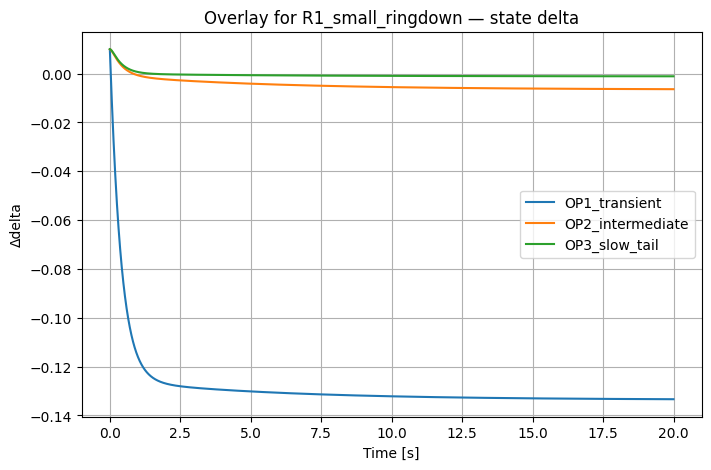

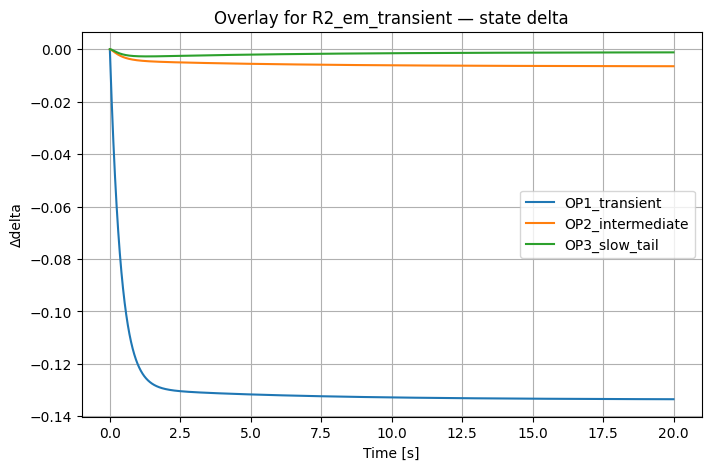

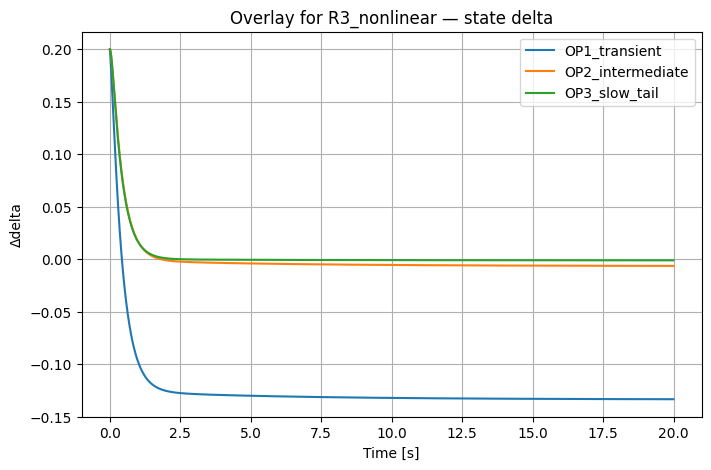

In [54]:
def plot_scenarios_overlay(scenarios, regime_id, state_idx=0, t_max=20.0):
    plt.figure(figsize=(8,5))
    for sc in scenarios:
        if sc["regime_id"] != regime_id:
            continue
        sol = sc["sol"]
        t = sol.t
        y = sol.y[state_idx] - sc["x_ref"][state_idx]
        mask = t <= t_max
        plt.plot(t[mask], y[mask], label=f"{sc['op_id']}")
    plt.xlabel("Time [s]")
    plt.ylabel(f"Δ{state_names[state_idx]}")
    plt.title(f"Overlay for {regime_id} — state {state_names[state_idx]}")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_scenarios_overlay(scenarios, "R1_small_ringdown", state_idx=0)
plot_scenarios_overlay(scenarios, "R2_em_transient",   state_idx=0)
plot_scenarios_overlay(scenarios, "R3_nonlinear",      state_idx=0)